In [1]:
import jax
jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp

In [4]:
from funciones import  scalar_ASM

In [9]:
from scipy import integrate
from scipy.integrate import simpson
from scipy import interpolate
def get_MA_nearfield_phase_fun_2(input_fun, target_fun , extent_input, extent_target, λ, z, integration_points = 500000):
    """
    Solves Eq.(2.1.11) using the method described in section 2.1.4
    
    Parameters
    ----------
    input_fun, target_fun: 1D functions with I(r) and E(t) as defined in section 2.1.2 
    extent_input, extent_target: float values with 
    λ, z: wavelength in the propagating medium and target profile distance
    integration_points: number of samples to use for the numerical integration
    """
    r = np.linspace(0,extent_input, integration_points) #input r coordinates
    I = input_fun(r) #incident intensity profile
    t = np.linspace(0,extent_target, integration_points) #target t coordinates
    E = target_fun(t) #target intensity profile
    PI,PE = simpson(r*I, r), simpson(t*E, t) # compute total power
    E = PI/PE*E  # scale the target profile to conserve energy
    int_I = np.array(integrate.cumtrapz(r*I, r, initial=0) ) #evaluate left hand side of Eq.(2.1.19)
    int_E = np.array(integrate.cumtrapz(t*E, t, initial=0) ) #evaluate right hand side of Eq.(2.1.19)
    int_E, idx = np.unique(int_E, return_index=True) # remove repeated values
    t = t[idx]
    
    int_E_inv_fun = interpolate.interp1d(int_E, t, kind="linear",bounds_error=False ,fill_value = (t.min(), t.max()))
    t = int_E_inv_fun(int_I) #evaluate Eq.(2.1.20)
    T_fun = interpolate.interp1d(r, t, kind="cubic",bounds_error=False, fill_value = (t.min(), t.max()))
    t =  T_fun(r) #define T(R) from Eq.(2.1.20)  using interpolation
    
    dΦ_dr = (-t - r) / np.sqrt(z**2 +  (-t - r)**2 ) # Right hand side of Eq.(2.1.21)
    Φ = (2*np.pi / λ)  * integrate.cumtrapz(dΦ_dr, r, initial=0)  #Integrate Eq.(2.1.21)
    Φ_fun = interpolate.interp1d(r, Φ - Φ[0], kind="cubic",bounds_error=False , fill_value = Φ.max())
    return Φ_fun, PI/ PE


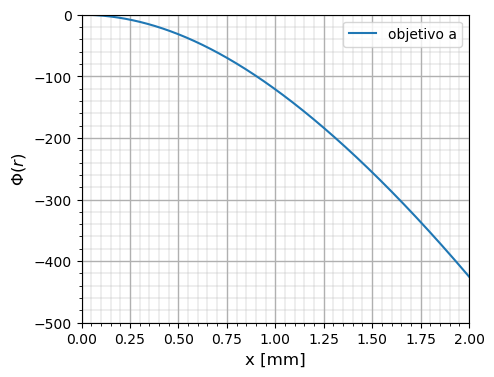

In [14]:
um = 1
mm = 1000*um
cm = 10000*um
extent_x = extent_y = W = 12*mm

λ = 0.633*um
w_I = 1500*um 
w_E = 1800*um 

n = 20

L = 10*cm

Nx = 2048
Ny = 2048

extent_input = extent_x/2
extent_target = extent_x/2

def target_fun(t):
    E = (np.where(t< extent_target,  np.exp(-(t/w_E)**n), 0))
    return E**2
def input_fun(r):
    E = (np.where(r< extent_input,  np.exp(-(r/w_I)**2), 0))
    return E**2


Φ_fun,target_scale = get_MA_nearfield_phase_fun_2(input_fun, target_fun , extent_input, extent_target, λ, L)

def target_fun(t):
    E = (np.where(t< extent_target,  np.exp(-(t/w_E)**n), 0))
    return target_scale * E**2

r_ = np.linspace(0,extent_input, 500000)
phase1 = Φ_fun(r_)



######################################################

fig = plt.figure(figsize = (5,4))
ax = fig.add_subplot(1,1,1)

ax.plot(r_/1000, phase1, label ='objetivo a')

ax.set_xlim([0,2])

ax.set_ylim([-500,0])

ax.set_xlabel("x [mm]", size= 12)
ax.set_ylabel(r"$\Phi(r)$", size= 12)
ax.grid(True)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth=1.0)
ax.grid(which='minor', linestyle='-', linewidth=0.3)

plt.legend()
plt.show()



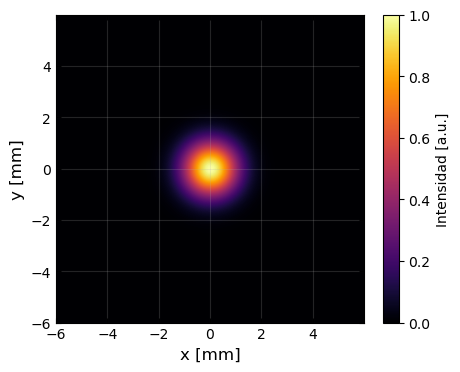

In [15]:
dx = extent_x/Nx
dy = extent_y/Ny
x = dx*(np.arange(Nx)-Nx//2)
y = dy*(np.arange(Ny)-Ny//2)
xx, yy = np.meshgrid(x, y)
rr = np.sqrt(xx**2 +  yy**2)


E = np.sqrt(input_fun(rr))*np.exp(1j*(Φ_fun(rr)  ))


fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(1,1,1)

im = ax.imshow(np.abs(E)**2, origin = 'lower', cmap ='inferno',    extent = [xx[0,0]/mm ,xx[0,-1]/mm ,yy[0,0]/mm ,yy[-1,0]/mm ])
cb1 = fig.colorbar(im, orientation = 'vertical')
cb1.set_label('Intensidad [a.u.]')

ax.set_xlabel("x [mm]", size= 12)
ax.set_ylabel("y [mm]", size= 12)

#ax.set_title(r"Far Field Radiance $L(θ_x,θ_y)=\frac{\partial \Phi(θ_x,θ_y)}{\partial \Omega \cos(\theta)} $ (NN 7x7 simulation)")
#ax.set_ylabel("$sin(θ_y)$")
#ax.set_xlabel('$sin(θ_x)$')
plt.grid(alpha =0.2)
ax.tick_params(axis='both', which="both", direction="in",right=True, top=True,)
#ax.set_xlim([-2, 2])
#ax.set_ylim([-2, 2])


plt.show()

#fig.savefig(f'diffuser_L_Cmodel.png', dpi=fig.dpi, transparent = False, facecolor='white')


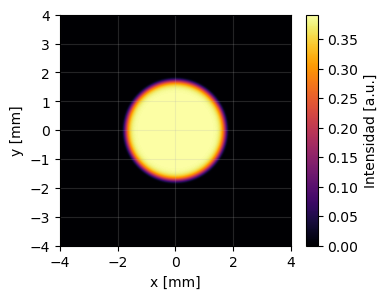

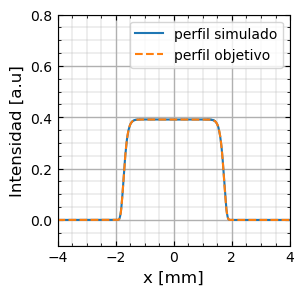

In [16]:
E = scalar_ASM(x, y, np.sqrt(input_fun(rr))*np.exp(1j*(Φ_fun(rr)  )), L, λ)

fig = plt.figure(figsize=(4,3)) 
ax = fig.add_subplot(1,1,1)  
ax.set_ylabel("y [mm]")
ax.set_xlabel('x [mm]')

ax.grid(alpha =0.2)

ax.set_ylim([-4,4])
ax.set_xlim([-4,4])



im = ax.imshow(jnp.abs(E)**2, interpolation = 'spline36', origin = 'lower', cmap = 'inferno', extent = [x[0]/mm, x[-1]/mm ,y[0]/mm, y[-1]/mm ], aspect = 'auto')

label_ax = ax.text(0.97,0.97, "",  color = "black",
                transform=ax.transAxes, ha="right", va="top", size=10, bbox=dict(boxstyle="round", fc="w", ec="k"), backgroundcolor = 'black')
#label_ax.set_text(f"z = {10} cm")
ax.set_aspect('equal')
cb1 = fig.colorbar(im, orientation = 'vertical')
cb1.set_label('Intensidad [a.u.]')

plt.show()



#############################################


fig = plt.figure(figsize = (3.0,3))
ax = fig.add_subplot(1,1,1)
ax.tick_params(axis='both', which="both", direction="in",right=True, top=True,)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth=1.0)

ax.set_xlim([-4,4])
ax.set_ylim([-0.1,0.8])


λ1 = λ
I1_00 = np.abs(E[Ny//2,:])**2 
target = target_fun(x)


ax.plot(x/mm , I1_00, label = 'perfil simulado' )
ax.plot(x/mm , target, '--', label = 'perfil objetivo' ) 
ax.set_xlabel("x [mm]", size= 12)
ax.set_ylabel("Intensidad [a.u]", size= 12)
ax.grid(True)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth=1.0)
ax.grid(which='minor', linestyle='-', linewidth=0.3)


plt.legend()
plt.show()





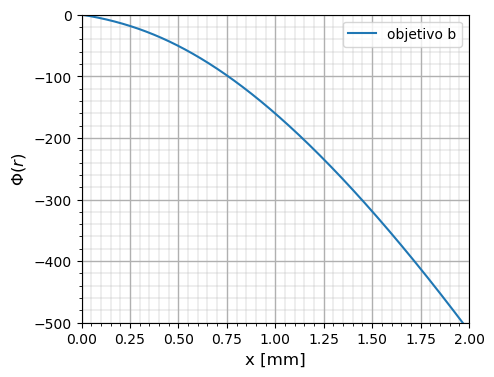

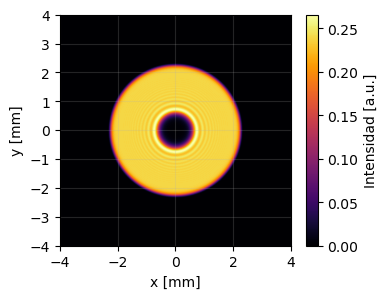

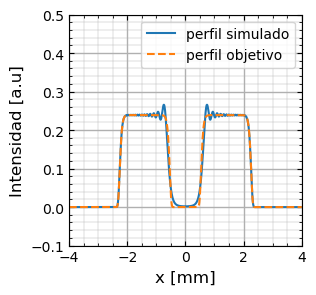

In [17]:
mm = 1000*um
cm = 10000*um
extent_x = extent_y = W = 12*mm

λ = 0.633*um
w_I = 1500*um 
w_E = 900*um 

n = 18

L = 10*cm

Nx = 3000
Ny = 3000

extent_input = extent_x/2
extent_target = extent_x/2

def target_fun(t):
    E = (np.where(t< extent_target,  np.exp(-((np.abs(t)-1400*um)/w_E)**n), 0))
    return E**2
def input_fun(r):
    E = (np.where(r< extent_input,  np.exp(-(r/w_I)**2), 0))
    return E**2

Φ_fun,target_scale = get_MA_nearfield_phase_fun_2(input_fun, target_fun , extent_input, extent_target, λ, L)

def target_fun(t):
    E = (np.where(t< extent_target,  np.exp(-((np.abs(t)-1400*um)/w_E)**n), 0))
    return target_scale * E**2


r_ = np.linspace(0,extent_input, 500000)
phase2 = Φ_fun(r_)

######################################################

fig = plt.figure(figsize = (5,4))
ax = fig.add_subplot(1,1,1)

ax.plot(r_/1000, phase2, label ='objetivo b')

ax.set_xlim([0,2])
ax.set_ylim([-500,0])

ax.set_xlabel("x [mm]", size= 12)
ax.set_ylabel(r"$\Phi(r)$", size= 12)
ax.grid(True)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth=1.0)
ax.grid(which='minor', linestyle='-', linewidth=0.3)

plt.legend()
plt.show()

dx = extent_x/Nx
dy = extent_y/Ny
x = dx*(np.arange(Nx)-Nx//2)
y = dy*(np.arange(Ny)-Ny//2)
xx, yy = np.meshgrid(x, y)
rr = np.sqrt(xx**2 +  yy**2)


E = scalar_ASM(x, y, np.sqrt(input_fun(rr))*np.exp(1j*(Φ_fun(rr)  )), L, λ)


fig = plt.figure(figsize=(4,3)) 
ax = fig.add_subplot(1,1,1)  
ax.set_ylabel("y [mm]")
ax.set_xlabel('x [mm]')

ax.grid(alpha =0.2)

ax.set_ylim([-4,4])
ax.set_xlim([-4,4])



im = ax.imshow(jnp.abs(E)**2, interpolation = 'spline36', origin = 'lower', cmap = 'inferno', extent = [x[0]/mm, x[-1]/mm ,y[0]/mm, y[-1]/mm ], aspect = 'auto')

label_ax = ax.text(0.97,0.97, "",  color = "black",
                transform=ax.transAxes, ha="right", va="top", size=10, bbox=dict(boxstyle="round", fc="w", ec="k"), backgroundcolor = 'black')
#label_ax.set_text(f"z = {10} cm")
ax.set_aspect('equal')
cb1 = fig.colorbar(im, orientation = 'vertical')
cb1.set_label('Intensidad [a.u.]')

plt.show()



#############################################


fig = plt.figure(figsize = (3.0,3))
ax = fig.add_subplot(1,1,1)
ax.tick_params(axis='both', which="both", direction="in",right=True, top=True,)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth=1.0)

ax.set_xlim([-4,4])
ax.set_ylim([-0.1,0.5])


λ1 = λ
I1_00 = np.abs(E[Ny//2,:])**2 
target = target_fun(x)

ax.plot(x/mm , I1_00, label = 'perfil simulado' )
ax.plot(x/mm , target, '--', label = 'perfil objetivo' ) 
ax.set_xlabel("x [mm]", size= 12)
ax.set_ylabel("Intensidad [a.u]", size= 12)
ax.grid(True)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth=1.0)
ax.grid(which='minor', linestyle='-', linewidth=0.3)


plt.legend()
plt.show()



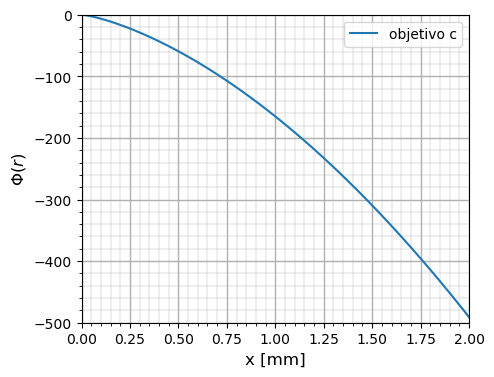

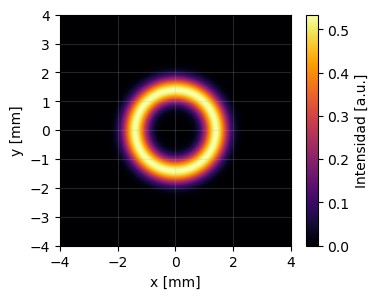

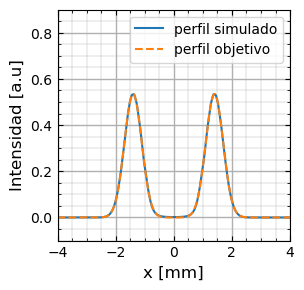

In [18]:
mm = 1000*um
cm = 10000*um
extent_x = extent_y = W = 12*mm

λ = 0.633*um
w_I = 1500*um 
w_E = 600*um 

n = 2

L = d_src_MOE1 = 10*cm

Nx = 3000
Ny = 3000

extent_input = extent_x/2
extent_target = extent_x/2

def target_fun(t):
    E = (np.where(t< extent_target,  np.exp(-((np.abs(t)-1400*um)/w_E)**n), 0))
    return E**2
def input_fun(r):
    E = (np.where(r< extent_input,  np.exp(-(r/w_I)**2), 0))
    return E**2



Φ_fun,target_scale = get_MA_nearfield_phase_fun_2(input_fun, target_fun , extent_input, extent_target, λ, L)

def target_fun(t):
    E = (np.where(t< extent_target,  np.exp(-((np.abs(t)-1400*um)/w_E)**n), 0))
    return target_scale * E**2


r_ = np.linspace(0,extent_input, 500000)
phase3 = Φ_fun(r_)

fig = plt.figure(figsize = (5,4))
ax = fig.add_subplot(1,1,1)

ax.plot(r_/1000, phase3, label ='objetivo c')

ax.set_xlim([0,2])
ax.set_ylim([-500,0])

ax.set_xlabel("x [mm]", size= 12)
ax.set_ylabel(r"$\Phi(r)$", size= 12)
ax.grid(True)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth=1.0)
ax.grid(which='minor', linestyle='-', linewidth=0.3)

plt.legend()
plt.show()


dx = extent_x/Nx
dy = extent_y/Ny
x = dx*(np.arange(Nx)-Nx//2)
y = dy*(np.arange(Ny)-Ny//2)
xx, yy = np.meshgrid(x, y)
rr = np.sqrt(xx**2 +  yy**2)


E = scalar_ASM(x, y, np.sqrt(input_fun(rr))*np.exp(1j*(Φ_fun(rr)  )), L, λ)


fig = plt.figure(figsize=(4,3)) 
ax = fig.add_subplot(1,1,1)  
ax.set_ylabel("y [mm]")
ax.set_xlabel('x [mm]')

ax.grid(alpha =0.2)

ax.set_ylim([-4,4])
ax.set_xlim([-4,4])



im = ax.imshow(jnp.abs(E)**2, interpolation = 'spline36', origin = 'lower', cmap = 'inferno', extent = [x[0]/mm, x[-1]/mm ,y[0]/mm, y[-1]/mm ], aspect = 'auto')

label_ax = ax.text(0.97,0.97, "",  color = "black",
                transform=ax.transAxes, ha="right", va="top", size=10, bbox=dict(boxstyle="round", fc="w", ec="k"), backgroundcolor = 'black')
#label_ax.set_text(f"z = {10} cm")
ax.set_aspect('equal')
cb1 = fig.colorbar(im, orientation = 'vertical')
cb1.set_label('Intensidad [a.u.]')

plt.show()



#############################################


fig = plt.figure(figsize = (3.0,3))
ax = fig.add_subplot(1,1,1)
ax.tick_params(axis='both', which="both", direction="in",right=True, top=True,)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth=1.0)

ax.set_xlim([-4,4])
ax.set_ylim([-0.1,0.9])


λ1 = λ
I1_00 = np.abs(E[Ny//2,:])**2 
target = target_fun(x)

ax.plot(x/mm , I1_00, label = 'perfil simulado' )
ax.plot(x/mm , target, '--', label = 'perfil objetivo' ) 
ax.set_xlabel("x [mm]", size= 12)
ax.set_ylabel("Intensidad [a.u]", size= 12)
ax.grid(True)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth=1.0)
ax.grid(which='minor', linestyle='-', linewidth=0.3)


plt.legend()
plt.show()



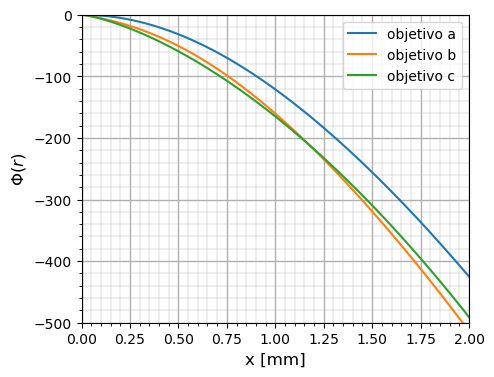

In [19]:
fig = plt.figure(figsize = (5,4))
ax = fig.add_subplot(1,1,1)

r_ = np.linspace(0,extent_input, 500000)

ax.plot(r_/1000, phase1, label ='objetivo a')
ax.plot(r_/1000, phase2, label ='objetivo b')
ax.plot(r_/1000, phase3, label ='objetivo c')

ax.set_xlim([0,2])
ax.set_ylim([-500,0])

ax.set_xlabel("x [mm]", size= 12)
ax.set_ylabel(r"$\Phi(r)$", size= 12)
ax.grid(True)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth=1.0)
ax.grid(which='minor', linestyle='-', linewidth=0.3)

plt.legend()
plt.show()
